One possible approach to efficiently calculate a function value at a point is the so called __*lookup table*__.

Define the function lookup_table(x) which calculates approximately the value of the function $f(x) = \sin(\sqrt x)$
in the interval $[0; 2\pi]$.

The function should use 2 arrays:
* **nodes** - equidistant nodes in the interval $[0; 2\pi]$ at a distace $h=0.01$
* **vales** - values of the function f, calculated at the nodes in the **nodes** array

The function should:
* accept $x \in [0; 2\pi]$;
* if $x$ is equal to a node in the **nodes** array, then the corresponding value should be returned;
* if $x \in (0; 0.01) \bigcup\space (2\pi - 0.01; 2\pi)$, then the function should construct an interpolation polynomial with the 3 closest to $x$ nodes (so that the polynomial is of $2^{nd}$ degree) and return the value of the interpolation polynomial evaluated at $x$;
* if $x \in (0.01; 2\pi - 0.01)$, then the function should construct an interpolation polynomial with the 4 closest to $x$ nodes (so that the polynomial is of $3^{rd}$ degree) and return the value of the interpolation polynomial evaluated at $x$.

In [17]:
import numpy as np
import bisect
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../util')

from lagrange_poly import lagrange_poly

In [13]:
f = lambda x: np.sin(np.sqrt(x))

In [67]:
def look_up_table_f(
    x,
    function=f,
    interval_begin=0,
    interval_end=2*np.pi,
    h=0.01,
    verbose=False,
    should_plot=False
):
    interval_begin = round(interval_begin, 2)
    interval_end = round(interval_end, 2)

    if x < interval_begin or x > interval_end:
        if verbose == True:
            print(f'x: {x}, should be in the interval [{interval_begin}, {interval_end}]', file=sys.stderr)

        return None

    nodes = [i * h for i in range(int((interval_end - interval_begin) * 100) + 1)]
    values = function(nodes)

    if nodes[index := bisect.bisect_left(nodes, x)] == x:
        if verbose == True:
            print(f'A node at {x} already exists; simply returning a predetermined value: {values[index]}')
            
        return values[index]

    def interpolate(nodes, values, x):
        if verbose == True:
            print('Interpolating the nodes:', nodes, 'and corresponding values:', values, 'for x:', x)

        if should_plot == True:
            x_axis = np.linspace(nodes.min(), nodes.max(), 300)

            plt.scatter(nodes, values, color='purple')
            plt.scatter([x], [function(x)], color='green')
            plt.scatter([x], [lagrange_poly(nodes, values, x)], color='red')
            plt.plot(x_axis, function(x_axis), linestyle='dashed', color='black')
            plt.plot(x_axis, lagrange_poly(nodes, values, x_axis))
            plt.legend(['nodes', f'exact value of f({x})', f'approximated value of f({x})', 'f(x)', 'interpolation poly'])
            plt.show()

        return lagrange_poly(nodes, values, x)

    if interval_end - x < h or x - interval_begin < h:
        if interval_end - x < h:
            nodes = np.flip(nodes)
            values = np.flip(values)

        return interpolate(np.array(nodes[0:3]), np.array(values[0:3]), x)

    def get_neighbors(x):
        for i in range(len(nodes) - 1):
            if nodes[i] == x:
                return nodes[i-1], nodes[i+1]
            if nodes[i] < x and x < nodes[i+1]:
                return nodes[i], nodes[i+1]

    get_index = lambda node_value: bisect.bisect_left(nodes, node_value)

    left1, right1 = get_neighbors(x)

    left2, _ = get_neighbors(left1)
    _, right2 = get_neighbors(right1)

    assert left2 < left1 and left1 < x and x < right1 and right1 < right2, 'The interpolation nodes are incorrect'

    interpolation_nodes = np.array([
        left2,
        left1,
        right1,
        right2,
    ])

    interpolation_values = np.array([
        values[get_index(left2)],
        values[get_index(left1)],
        values[get_index(right1)],
        values[get_index(right2)],
    ])

    return interpolate(interpolation_nodes, interpolation_values, x)

## Test cases

#### A general case, where x is in the right interval and there isn't an existing node equal to x.

As expected there are 4 interpolation nodes so that the interpolation polynomial is of $3^{rd}$ degree.

Interpolating the nodes: [1.59 1.6  1.61 1.62] and corresponding values: [0.95238105 0.95358074 0.95476181 0.95592441] for x: 1.602311


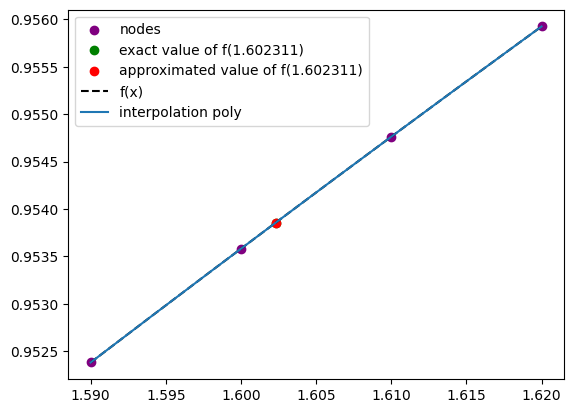

Approximated value of sin(sqrt(1.602311)) 0.9538553335959832
Exact value of sin(sqrt(1.602311)) 0.9538553335617003


In [68]:
x = 1.602311

print(f'Approximated value of sin(sqrt({x}))', look_up_table_f(x, verbose=True, should_plot=True))
print(f'Exact value of sin(sqrt({x}))', f(x))

#### A case, where x is in the right interval and there is an existing node equal to x.

The predetermined value is returned without interpolation.

In [70]:
x = 1.62

print(f'Looked up value of sin(sqrt({x}))', look_up_table_f(x, verbose=True, should_plot=True))
print(f'Exact value of sin(sqrt({x}))', f(x))

A node at 1.62 already exists; simply returning a predetermined value: 0.9559244086020748
Looked up value of sin(sqrt(1.62)) 0.9559244086020748
Exact value of sin(sqrt(1.62)) 0.9559244086020748


#### A case, where x is in the interval $(0; 0.01)$

As expected an interpolation polynomial of $2^{nd}$ degree is constructed with 3 interpolation nodes.

> The approximation isn't very good because the degree is too low and the behaviour of $\sin(\sqrt x)$ close to the zero is particular.

Interpolating the nodes: [0.   0.01 0.02] and corresponding values: [0.         0.09983342 0.14095042] for x: 0.0075


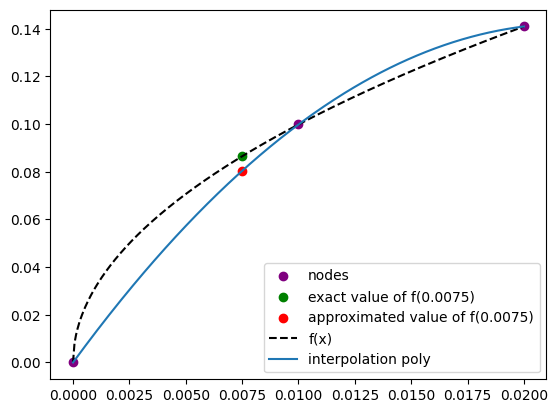

Approximated value of sin(sqrt(0.0075)) 0.08037972595984295
Exact value of sin(sqrt(0.0075)) 0.08649432779066327


In [72]:
x = 0.0075

print(f'Approximated value of sin(sqrt({x}))', look_up_table_f(x, verbose=True, should_plot=True))
print(f'Exact value of sin(sqrt({x}))', np.sin(np.sqrt(x)))

#### A case, where x is in the interval $(2\pi - 0.01; 2 \pi)$

As expected an interpolation polynomial of $2^{nd}$ degree is constructed with 3 interpolation nodes.

Interpolating the nodes: [6.28 6.27 6.26] and corresponding values: [0.59366032 0.59526536 0.5968693 ] for x: 6.2748


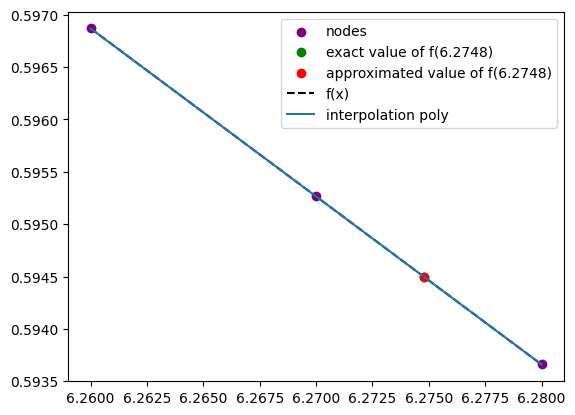

Approximated value of sin(sqrt(6.2748)) 0.594495075550323
Exact value of sin(sqrt(6.2748)) 0.594495074995542


In [73]:
x = 6.2748

print(f'Approximated value of sin(sqrt({x}))', look_up_table_f(x, verbose=True, should_plot=True))
print(f'Exact value of sin(sqrt({x}))', np.sin(np.sqrt(x)))

#### Cases, where x is outside the right interval

In [74]:
x = -4.311

look_up_table_f(x, verbose=True)

x: -4.311, should be in the interval [0, 6.28]


In [75]:
x = 72

look_up_table_f(x, verbose=True)

x: 72, should be in the interval [0, 6.28]
